<a href="https://colab.research.google.com/github/djmMax/sample-a-heatmap/blob/main/Sample_from_Heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## generate a heatmap

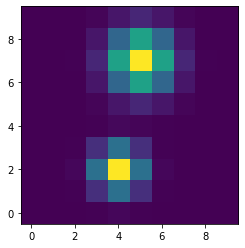

In [ ]:
from scipy.stats import multivariate_normal

pos = np.dstack(np.mgrid[0:10:1, 0:10:1])

# hotspot at pixel mean=(22, 43) with roughly 4-pixel radial spread
rv = multivariate_normal(mean=[2, 4], cov=0.5)
heatmap = rv.pdf(pos)

rv = multivariate_normal(mean=[7, 5], cov=0.9)
heatmap2 = rv.pdf(pos)
# heatmap += rv.pdf(pos)

heatmap = heatmap/heatmap.max() + heatmap2/heatmap2.max()

plt.imshow(heatmap, origin='lower');

In [ ]:
heatmap = torch.from_numpy(heatmap)

In [ ]:
heatmap.min(), heatmap.max(), heatmap.sum()

(tensor(2.5457e-13, dtype=torch.float64),
 tensor(1.0000, dtype=torch.float64),
 tensor(8.7805, dtype=torch.float64))

## be sure the sum of element is 1, no less, no more

In [ ]:
# T = 5
# h_ = torch.nn.functional.softmax(T*heatmap.view(-1), dim=0).reshape_as(heatmap)
# # plt.imshow(h_);
# h_.numpy().sum()

heatmap = heatmap / heatmap.sum() 

In [ ]:
(heatmap * 100).long()#.view(-1)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  4,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  4, 11,  4,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  4,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  3,  6,  3,  0,  0,  0],
        [ 0,  0,  0,  1,  6, 11,  6,  1,  0,  0],
        [ 0,  0,  0,  0,  3,  6,  3,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0]])

# Approach 1

### genereate sample of grid following the heatmap

In [ ]:
w,h = heatmap.shape
n = 10000

rand_grid = np.random.choice(w*h, size=n, p=heatmap.view(-1)) #.reshape(h_.shape)
# rand_section

### generate random points

In [ ]:
points_cloud = np.random.rand(n,2)
points_cloud, points_cloud.min(), points_cloud.max()

(array([[0.97993313, 0.07491796],
        [0.37958509, 0.16146291],
        [0.98057652, 0.70623163],
        ...,
        [0.7013318 , 0.9232041 ],
        [0.83379835, 0.22964152],
        [0.18226983, 0.0084533 ]]), 3.4833309168869064e-05, 0.9998788154137586)

### align the generated points to the random grid from the heatmap

In [ ]:
points_cloud[:, 0] += rand_grid // w
points_cloud[:, 1] += rand_grid % w

## Everything in one function

In [ ]:
def sample_heatmap(heatmap, n):
    '''
        heatmap : torch tensor shape (W x H)
        n: number of sample

        ouput: sample shape (N,2) of point following the distribution
    '''
    heatmap = heatmap / heatmap.sum()
    w,h = heatmap.shape

    # pick rand section arcoding to the distribtuion
    rand_section = np.random.choice(w*h, size=n, p=heatmap.view(-1))
    
    points_cloud = np.random.rand(n,2)
    points_cloud[:, 0] += rand_section % w
    points_cloud[:, 1] += rand_section // w

    return points_cloud

## Visualization

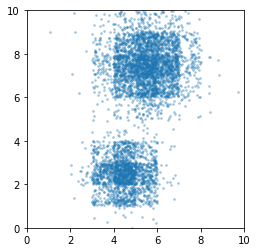

The result follow the heatmap but is still pixelized 
An approach using a densitity distribution will be better discret the one i use here


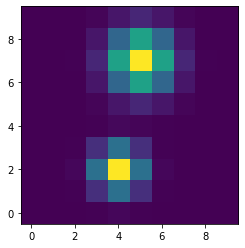

In [ ]:
points_cloud = sample_heatmap(heatmap, n=5000)
w,h = heatmap.shape

plt.scatter(points_cloud[:, 0], points_cloud[:, 1], alpha=0.3, s=3)
plt.axis('scaled')
plt.xlim(0, w)
plt.ylim(0, h)
plt.show();

plt.imshow(heatmap, origin='lower');

print('The result follow the heatmap but is still pixelized \nAn approach using a densitity distribution will be better discret the one i use here')

# Approach 2

In [ ]:
# import numpy as np
# from scipy import interpolate

# map_x = np.arange(0, 1, 1/10)
# map_y = np.arange(0, 1, 1/10)
# _heatmap = interpolate.interp2d(map_x, map_y, heatmap, kind='cubic')

# _heatmap

In [ ]:
h = [0.2,0.3,0.4,0.1] #indices 0,1,2
map_x = np.arange(0, 1, 1/4) #interpolated pixel coords
print(map_x)
_heatmap = interpolate.interp1d(map_x, h, kind='cubic')

_heatmap(0.2)

[0.   0.25 0.5  0.75]


array(0.2672)

In [ ]:
np.random.rand(5) < 0.5

array([ True,  True, False,  True, False])

In [ ]:
from scipy import interpolate

def sample_interpolate_heatmap(heatmap, n):
    '''
        heatmap : torch tensor shape (W x H)
        n: number of sample

        ouput: sample shape (N,2) of point following the distribution
    '''
    heatmap = heatmap / heatmap.sum()
    w,h = heatmap.shape
    print('w,h', w,h)

    # interpolate of the heatmap
    map_x = np.arange(0, 1, 1/w) #new pixel locations defined between 0 and 1
    map_y = np.arange(0, 1, 1/h)

    print('map_x', map_x)
    print('map_y', map_y)

    #interpolate heatmap to fall within defined pixel locations
    #the interpolated function can estimate values for any continous location betwen 0 and 1

    _heatmap = interpolate.interp2d(map_x, map_y, heatmap, kind='cubic')

    size = 0
    points_cloud = []
    while size < n:
        sample_size = (n-size)*w*h
        print('sample_size', sample_size)

        x = np.random.rand(sample_size)
        y = np.random.rand(sample_size)
        print('x, y', x, y)
        
        # estimate the probability at x,y with the interpolation of the heatmap 
        prob = [_heatmap(_x, _y)[0] for _x, _y in zip(x,y)] #have to be optimized
        print('prob', len(prob))
        # prob = _heatmap(x, y).diagonal() #have to be optimized
        # chunck = 30
        # prob = np.concatenate([ _heatmap(x[i:i+chunck], y[i:i+chunck]).diagonal() for i in range(0,sample_size,chunck) ])  #have to be optimized

        #sampling following the probability distribution
        mask_ = np.random.rand(sample_size) < prob
        print('mask_', mask_)

        x, y = x[mask_], y[mask_]
        print('x, y', x, y)
        

        points_cloud.append(np.stack((x,y)).T)
        print('sum(mask_)', sum(mask_))
        size += sum(mask_)
        # print('Loop %d - %.4e' % (size, n/size))
    
    return np.concatenate(points_cloud)[:n]

In [ ]:
%%time
points_cloud = sample_interpolate_heatmap(heatmap, n=5000)

w,h 10 10
map_x [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
map_y [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
sample_size 500000
x, y [0.27237146 0.67803956 0.01700752 ... 0.72399307 0.88535094 0.14348721] [0.80805291 0.85456464 0.70238746 ... 0.17595529 0.42874805 0.73746188]
prob 500000
mask_ [False False False ... False False False]
x, y [0.44505378 0.47376258 0.41202098 ... 0.42162273 0.52335953 0.38002398] [0.81572687 0.8463541  0.32397724 ... 0.27984822 0.7637079  0.69116326]
sum(mask_) 5156
CPU times: user 13.4 s, sys: 23.7 ms, total: 13.4 s
Wall time: 13.4 s


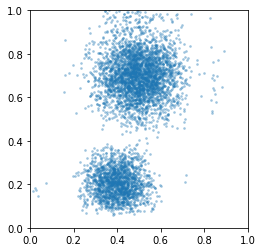

Looks better


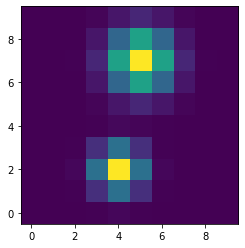

In [ ]:
plt.scatter(points_cloud[:, 0], points_cloud[:, 1], alpha=0.3, s=3)
plt.axis('scaled')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show();

print('Looks better')

plt.imshow(heatmap, origin='lower');

# Approach2 (execution time improvement)

In [ ]:
from scipy.interpolate import griddata
from scipy import interpolate

def sample_interpolate_heatmap(heatmap, n):
    '''
        heatmap : torch tensor shape (W x H)
        n: number of sample

        ouput: sample shape (N,2) of point following the distribution
    '''
    heatmap = heatmap / heatmap.sum()
    w,h = heatmap.shape

    # interpolate of the heatmap
    grid_y, grid_x = np.mgrid[0:1:(w*1j), 0:1:(h*1j)] # I reversed x and y coordinate
    grid_x, grid_y = grid_x.reshape(-1), grid_y.reshape(-1)
    grid_points = np.stack((grid_x,grid_y)).T
    print(grid_points[:,0].max(), grid_points[:,0].max())
    heatmap = heatmap.reshape(-1)
    # _heatmap = interpolate.interp2d(map_x, map_y, heatmap, kind='cubic')

    size = 0
    points_cloud = []
    while size < n:
        sample_size = (n-size)*w*h
        points = np.random.rand(sample_size, 2)
        
        # estimate the probability at x,y with the interpolation of the heatmap 
        prob = griddata(grid_points, heatmap, points, method='cubic')

        #sampling following the probability distribution
        mask_ = np.random.rand(sample_size) < prob
        points = points[mask_, :]

        points_cloud.append(points)
        size += sum(mask_)
        # print('Loop %d - %.4e' % (size, n/size))
    
    return np.concatenate(points_cloud)[:n]

In [ ]:
%%time
points_cloud = sample_interpolate_heatmap(heatmap, n=5000)

1.0 1.0
CPU times: user 1.45 s, sys: 107 ms, total: 1.55 s
Wall time: 1.43 s


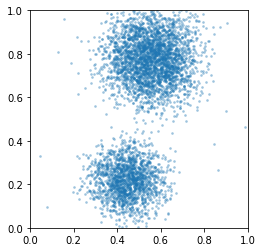

Same but faster


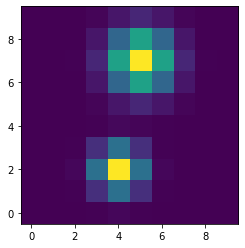

In [ ]:
plt.scatter(points_cloud[:, 0], points_cloud[:, 1], alpha=0.3, s=3)
plt.axis('scaled')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show();

print('Same but faster')

plt.imshow(heatmap, origin='lower');